# Module, Data 설정

In [7]:
# 상위 폴더를 파이썬 모듈 패스에 추가
import sys
sys.path.append("..")

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import recycle_dataset

In [106]:
# Get dataset
ds, info = tfds.load(
    'recycle_dataset',
    as_supervised=True,
    with_info=True,
)
get_label_name = info.features['label'].int2str
num_classes = info.features["label"].num_classes

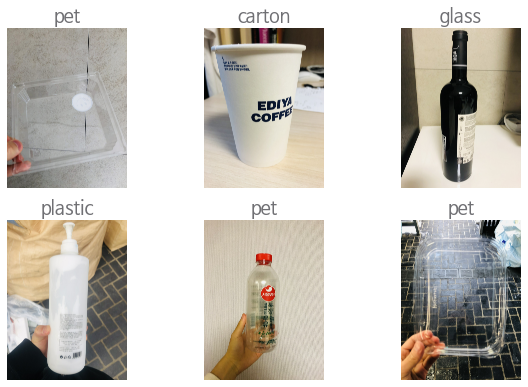

In [160]:
# Separate train dataset, test dataset
train_ds, test_ds = ds['train'], ds['test']
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.axis('off')
plt.show()

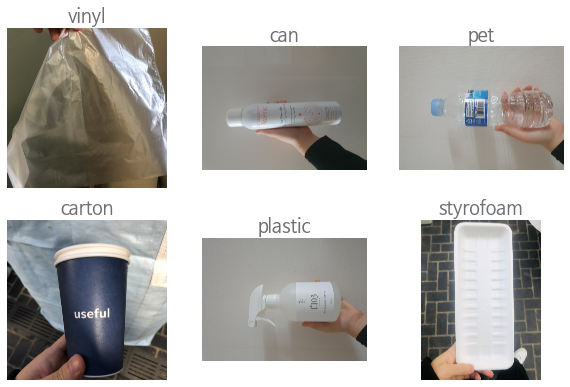

In [161]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(test_ds.take(6)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.axis('off')
plt.show()

# Preprocessing and Data augmentation
### Reference
https://www.tensorflow.org/tutorials/images/data_augmentation

Text(0.5, 1.0, 'pet')

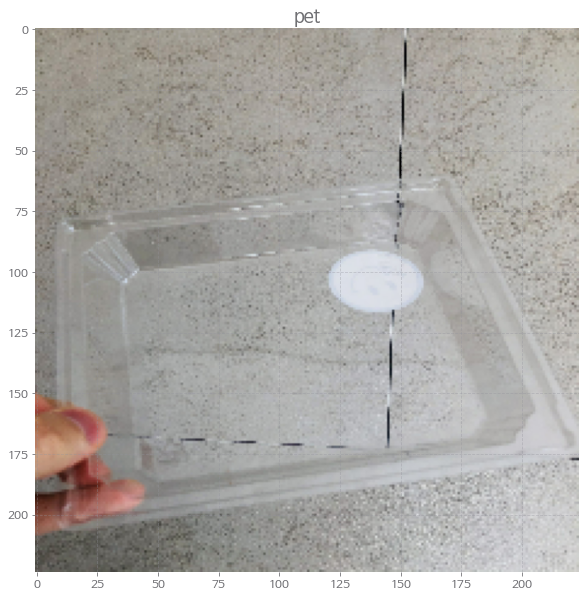

In [86]:
# Preprocessing (Resize, Rescaling)
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)  # RGB 채널 [0, 255] -> [0, 1]
])

# Preprocessing result
image, label = next(iter(train_ds.take(1)))
image = resize_and_rescale(image)
label = get_label_name(data_dict['label'].numpy())
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title(label)

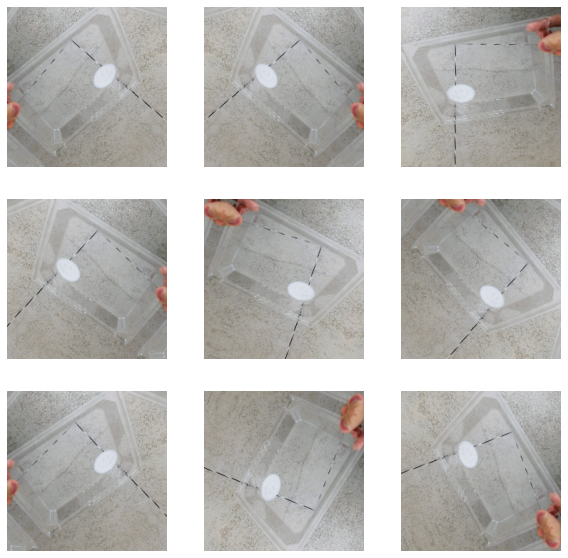

In [87]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Data augmentation result
image, label = next(iter(train_ds.take(1)))
image = resize_and_rescale(image)
image = tf.expand_dims(image, 0)
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

# Data loader
+ train_ds
   + resize, rescale 적용
   + data shuffle, augment 적용
+ test_ds
    + resize, rescale 적용

In [140]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale 적용
    ds = ds.map(
        lambda x, y: (resize_and_rescale(x), y), 
        num_parallel_calls=AUTOTUNE
    )
    
    
    # caching
    ds.cache()
    
    if shuffle:
        ds = ds.shuffle(1000)

    # batch 생성
    ds = ds.batch(batch_size)
    
    # 훈련 dataset 에만 augment 적용 
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y), 
            num_parallel_calls=AUTOTUNE
        )
    
    # Buffer size 만큼 미리 데이터를 준비하도록 설정
    return ds.prefetch(buffer_size=AUTOTUNE)

train_loader = prepare(train_ds, shuffle=True, augment=True)
test_loader = prepare(test_ds)

# 모델 생성
+ Base model
    + Mobilenetv1
+ Additional layer
    + Flatten()
    + Dense(8)

In [185]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)
mobilenet = tf.keras.applications.MobileNet(
    input_shape=input_shape, 
    include_top=False, 
    weights='imagenet', 
)

# 가중치 값 고정
mobilenet.trainable = False
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [191]:
learning_rate = 0.001

model = Sequential([
    mobilenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_classes)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(),
    ],
)
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_17 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               6422656   
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 1032      
Total params: 9,652,552
Trainable params: 6,423,688
Non-trainable params: 3,228,864
_________________________________________________________________


In [188]:
len(model.trainable_variables)

4

In [192]:
epochs=10
history = model.fit(
  train_loader,
  validation_data=test_loader,
  epochs=epochs
)

Epoch 1/10
14/14 [==============================] - 21s 265ms/step - loss: 17.3803 - sparse_categorical_accuracy: 0.2878 - val_loss: 6.1878 - val_sparse_categorical_accuracy: 0.3750
Epoch 2/10
14/14 [==============================] - 16s 217ms/step - loss: 2.8050 - sparse_categorical_accuracy: 0.6058 - val_loss: 4.5319 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/10
14/14 [==============================] - 16s 214ms/step - loss: 1.0039 - sparse_categorical_accuracy: 0.6858 - val_loss: 1.9043 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/10
14/14 [==============================] - 15s 214ms/step - loss: 0.6857 - sparse_categorical_accuracy: 0.7232 - val_loss: 2.3493 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/10
14/14 [==============================] - 15s 215ms/step - loss: 0.5602 - sparse_categorical_accuracy: 0.8220 - val_loss: 3.2335 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/10
14/14 [==============================] - 15s 209ms/step - loss: 0.5358 - sparse_cat

In [193]:
validation_steps=1
loss, accuracy = model.evaluate(test_loader, steps=validation_steps)

1/1 [==============================] - 0s 389ms/step - loss: 1.5742 - sparse_categorical_accuracy: 0.6250


# 예측결과 확인하기
## 2021.02.14 결과: Train dataset 에 대해서 Over fitting 되어 있는 것까지 확인

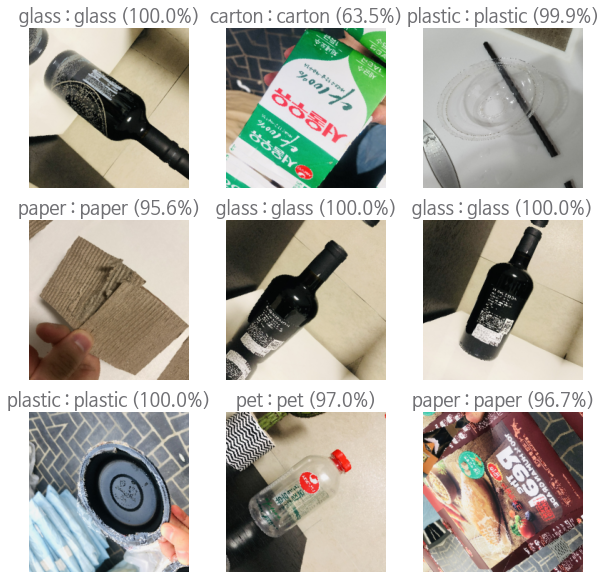

In [230]:
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_loader.take(1)):
    predictions = model.predict_on_batch(images)
    for i in range(9):
        score = tf.nn.softmax(predictions[i])
        label = np.argmax(score)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"{get_label_name(labels[i])} : {get_label_name(label)} ({100*np.max(score):.1f}%)")
        plt.axis("off")
